In [2]:
!pip install transformers
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
from transformers import AutoTokenizer,AutoModelForSequenceClassification;
from scipy.special import softmax
from tqdm.notebook import tqdm
import pandas as pd

In [2]:
df = pd.read_csv('Tweets.csv');
df = df.head(1000)
print(df);

FileNotFoundError: [Errno 2] No such file or directory: '../Tweets.csv'

In [ ]:
roberta = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(roberta)
roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta)

In [ ]:
def polarity_scores_roberta(example):
    encoded_tweet = tokenizer(example, return_tensors='pt')
    output = roberta_model(**encoded_tweet)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [31]:
tweets = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['text']
        myid = row['textID']
        roberta_result = polarity_scores_roberta(str(text))
        both = {**roberta_result}
        tweets[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1000 [00:00<?, ?it/s]

In [35]:
results_df = pd.DataFrame(tweets).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
print(results_df);

             Id  roberta_neg  roberta_neu  roberta_pos
0    cb774db0d1     0.064939     0.808318     0.126744
1    549e992a42     0.918158     0.066100     0.015742
2    088c60f138     0.924613     0.070741     0.004646
3    9642c003ef     0.783082     0.192980     0.023938
4    358bd9e861     0.564197     0.404575     0.031229
..          ...          ...          ...          ...
995  7c7a445b8d     0.013091     0.261733     0.725176
996  fe6301dd3a     0.862953     0.120915     0.016133
997  fd98097a71     0.691682     0.278413     0.029904
998  a7b4ba7093     0.000896     0.013317     0.985787
999  6d2170e60f     0.446783     0.399952     0.153265

[1000 rows x 4 columns]


In [64]:
tweet_result={}
for i, row in tqdm(results_df.iterrows(), total=len(results_df)):
    if row['roberta_neg'] > row['roberta_neu'] and row['roberta_neg'] > row['roberta_pos']:
      tweet_result[row['Id']]="negative"
    elif row['roberta_pos'] > row['roberta_neu'] and row['roberta_neg'] < row['roberta_pos']:
      tweet_result[row['Id']]="positive"
    else:
      tweet_result[row['Id']]="neutral"

tweet_results = pd.DataFrame([tweet_result]).T
tweet_results.columns = ['Sentiments']
tweet_results = tweet_results.reset_index().rename(columns={'index': 'Id'})
print(tweet_results);

  0%|          | 0/1000 [00:00<?, ?it/s]

0       neutral
1      negative
2      negative
3      negative
4      negative
         ...   
995    positive
996    negative
997    negative
998    positive
999    negative
Name: Sentiments, Length: 1000, dtype: object


In [103]:
cnt = tweet_results['Sentiments'].where(tweet_results['Sentiments'].values==df['sentiment'].values).notna()
# cnt1 = twee
rob_pos=tweet_results['Sentiments'].value_counts()['positive'];
rob_neg=tweet_results['Sentiments'].value_counts()['negative'];
rob_neu=tweet_results['Sentiments'].value_counts()['neutral'];

tes_pos = df['sentiment'].value_counts()['positive']
tes_neg = df['sentiment'].value_counts()['negative']
tes_neu = df['sentiment'].value_counts()['neutral']
print(rob_pos,rob_neg,rob_neu);
print(tes_pos,tes_neg,tes_neu);


390 317 293
315 294 391


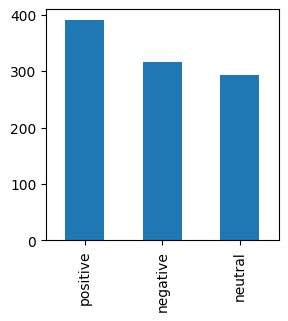

In [136]:
plt.figure(figsize=(3,3))
tweet_results['Sentiments'].value_counts().plot.bar();

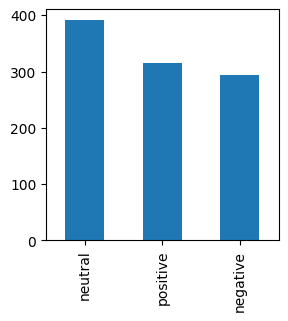

In [137]:
plt.figure(figsize=(3,3))

df['sentiment'].value_counts().plot.bar();

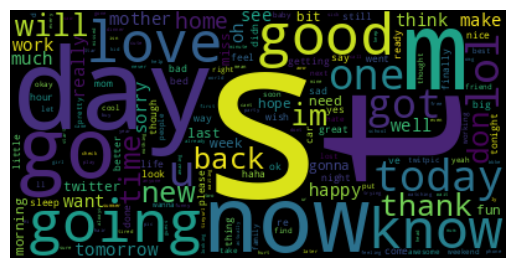

In [139]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

texts = " ".join(str(cat) for cat in df.text)
word_cloud = WordCloud(collocations = False, background_color = 'black').generate(texts)
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show();